In [46]:
#Load Dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import struct
import pandas as pd
from tqdm import tqdm
import copy

In [47]:
# === Step 1: Load MNIST Dataset ===
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows * cols)
        return images / 255.0
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels
# Students can experiment to modify number of Train
X_train = load_mnist_images("data/train-images.idx3-ubyte__")
y_train = load_mnist_labels("data/train-labels.idx1-ubyte__")
X_test = load_mnist_images("data/t10k-images.idx3-ubyte__")
y_test = load_mnist_labels("data/t10k-labels.idx1-ubyte__")

In [48]:
print(pd.DataFrame(X_train).info)

<bound method DataFrame.info of        0    1    2    3    4    5    6    7    8    9    ...  774  775  776  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
59999  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       777  778  77

In [49]:
print(pd.DataFrame(y_train).info)

<bound method DataFrame.info of        0
0      5
1      0
2      4
3      1
4      9
...   ..
59995  8
59996  3
59997  5
59998  6
59999  8

[60000 rows x 1 columns]>


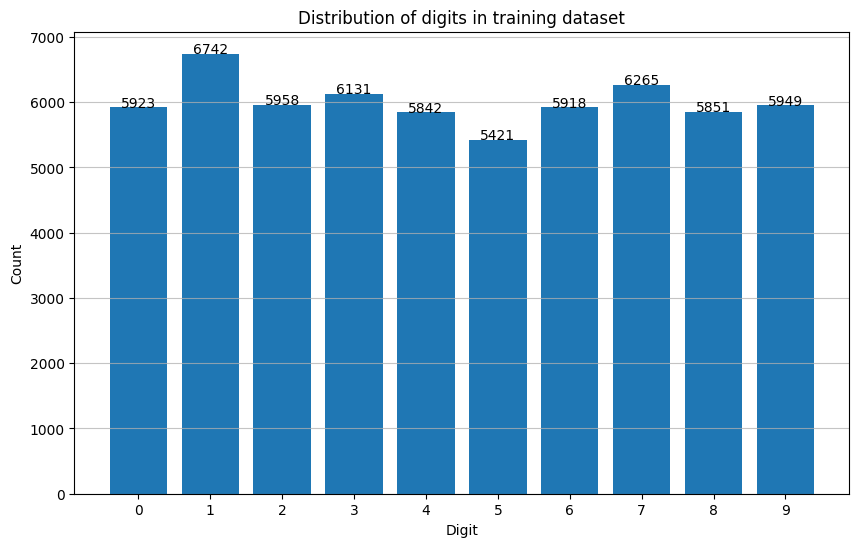

Label distribution in training dataset:
Class 0: 5923 samples (9.9%)
Class 1: 6742 samples (11.2%)
Class 2: 5958 samples (9.9%)
Class 3: 6131 samples (10.2%)
Class 4: 5842 samples (9.7%)
Class 5: 5421 samples (9.0%)
Class 6: 5918 samples (9.9%)
Class 7: 6265 samples (10.4%)
Class 8: 5851 samples (9.8%)
Class 9: 5949 samples (9.9%)


In [50]:
# Analyze the distribution of labels in y_train
label_counts = np.bincount(y_train)

# Create a bar chart to visualize the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(10), label_counts)
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of digits in training dataset')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.75)

# Add count labels on top of each bar
for i, count in enumerate(label_counts):
    plt.text(i, count + 1, str(count), ha='center')

# Display the chart
plt.show()

# Print the counts for each digit
print("Label distribution in training dataset:")
for i, count in enumerate(label_counts):
    print(f"Class {i}: {count} samples ({count/len(y_train)*100:.1f}%)")

In [51]:
# === Step 2: Activation Functions (Refer to Eq. 6.14 - 6.18) ===
def relu(x): 
    return np.maximum(0, x)

def tanh(x): 
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def softplus(x): 
    return np.log(1 + np.exp(x))

def leaky_relu(x, alpha=0.1): 
    return np.where(x > 0, x, alpha * x)

def softmax(a): # Refer to Equation 6.37
    exp_a = np.exp(a - np.max(a, axis=1, keepdims=True)) # For numerical stability
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

def one_hot(y, num_classes=10): # Refer to Equation 6.36
    N = y.shape[0]
    one_hot = np.zeros((N, num_classes))
    one_hot[np.arange(N), y] = 1
    return one_hot

def cross_entropy(y_pred, y_true): # Refer to Equation 6.36
    epsilon = 1e-12 # Prevent log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon) # Avoid unstable log
    return -np.sum(y_true * np.log(y_pred))

def forward_pass(X, weights, activations): # Forward Pass (Eq. 6.19) ===
    for w, activations in zip(weights, activations):
        z = activations(np.dot(X, w))
    return z

100%|██████████| 30/30 [00:08<00:00,  3.55it/s, epoch=29, loss=12.8311]


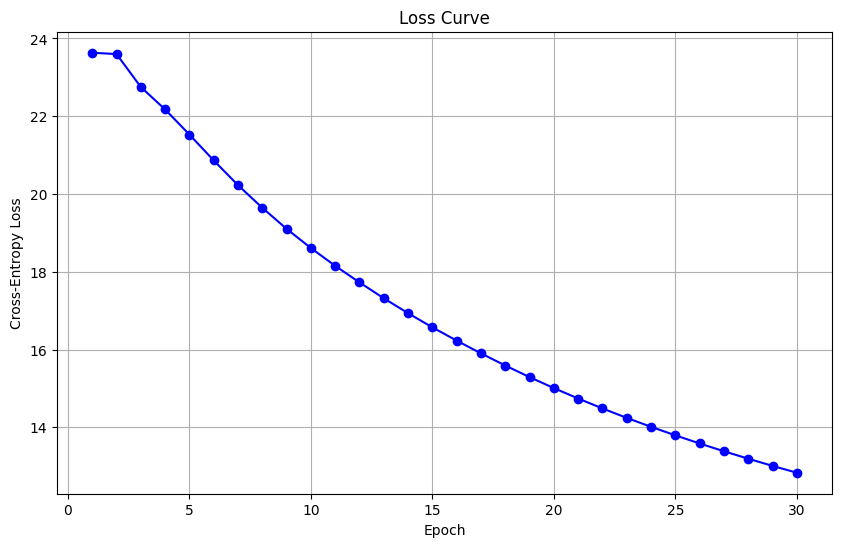

In [52]:
# === Step 3: Training Loop === # Students can experiment to modify
def train(X_train, y_train, input_size=784, hidden1=64, hidden2=32, output_size=10, epochs=30, learning_rate=0.01, seed=42):
    # TODO: Randomly initialize weights for each layer
    np.random.seed(seed)
    W1 = np.random.randn(input_size, hidden1)
    W2 = np.random.randn(hidden1, hidden2)
    W3 = np.random.randn(hidden2, output_size)
    weights = [W1, W2, W3]
    activations = [relu, relu, softmax] # Students can experiment to modify
    y_train_one_hot = one_hot(y_train, num_classes=output_size)
    losses = []
    best_loss = float('inf')
    best_weights = None
    N = X_train.shape[0]
    
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            # Forward pass
            z1 = activations[0](np.dot(X_train, weights[0]))
            z2 = activations[1](np.dot(z1, weights[1]))
            y_pred = activations[2](np.dot(z2, weights[2]))
            
            # Compute loss
            loss = cross_entropy(y_pred, y_train_one_hot) / N
            losses.append(loss)
            
            # Save
            if loss < best_loss:
                best_loss = loss
                best_weights = copy.deepcopy(weights)
            
            # Gradient descent
            delta3 = (y_pred - y_train_one_hot) / N # Cross-entropy derivative
            grad_w3 = np.dot(z2.T, delta3)
            
            delta2 = np.dot(delta3, weights[2].T) * (z2 > 0) # ReLU derivative
            grad_w2 = np.dot(z1.T, delta2)
            
            delta1 = np.dot(delta2, weights[1].T) * (z1 > 0) # ReLU derivative
            grad_w1 = np.dot(X_train.T, delta1)
        
            # Update weights
            weights[2] -= learning_rate * grad_w3
            weights[1] -= learning_rate * grad_w2
            weights[0] -= learning_rate * grad_w1

            pbar.set_postfix(epoch=f"{epoch}",loss=f"{loss:.4f}")
            pbar.update(1) 
    return best_weights, losses

best_weights, losses = train(X_train, y_train, input_size=784, hidden1=64, hidden2=32, output_size=10, epochs=30, learning_rate=0.01, seed=42)

def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses)+1), losses, marker='o', color='b')
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.grid()
    plt.show()
    
plot_loss(losses)

In [53]:
# === Predict Function ===
def predict_proba(X, weights):
    z1 = relu(np.dot(X, weights[0]))
    z2 = relu(np.dot(z1, weights[1]))
    y_pred_proba = softmax(np.dot(z2, weights[2]))
    return y_pred_proba
y_pred_proba = predict_proba(X_test, best_weights)

def predict(X, weights):
    z1 = relu(np.dot(X, weights[0]))
    z2 = relu(np.dot(z1, weights[1]))
    y_pred = softmax(np.dot(z2, weights[2]))
    return np.argmax(y_pred, axis=1)

y_pred_test = predict(X_test, best_weights)

In [54]:
# === Step 4: Evaluation Metrics (Confusion Matrix, ROC, etc) ===
def compute_confusion_matrix(y_true, y_pred, num_classes=10): 
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

# === ROC Curve ===
def compute_roc(y_true_oh, y_pred_proba): 
    thresholds = np.linspace(0, 1, 100)
    num_classes = y_true_oh.shape[1]
    roc_data = []
    for i in range (num_classes):
        tpr = []
        fpr = []
        for threshold in thresholds:
            y_pred_binay = (y_pred_proba[:, i] >= threshold).astype(int)
            cm = compute_confusion_matrix(y_true_oh[:, i].astype(int), y_pred_binay, num_classes=2)
            TN = cm[0, 0]
            FP = cm[0, 1]
            FN = cm[1, 0]
            TP = cm[1, 1]
            tpr.append(TP / (TP + FN))
            fpr.append(FP / (FP + TN))
        roc_data.append((fpr, tpr))
    return roc_data

def compute_metrics(cm): 
    num_classes = cm.shape[0]
    metrics = {}
    
    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * (precision * recall) / (precision + recall)
        
        metrics[i] = {
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'TN': TN,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    metrics['Accuracy'] = accuracy
    return metrics

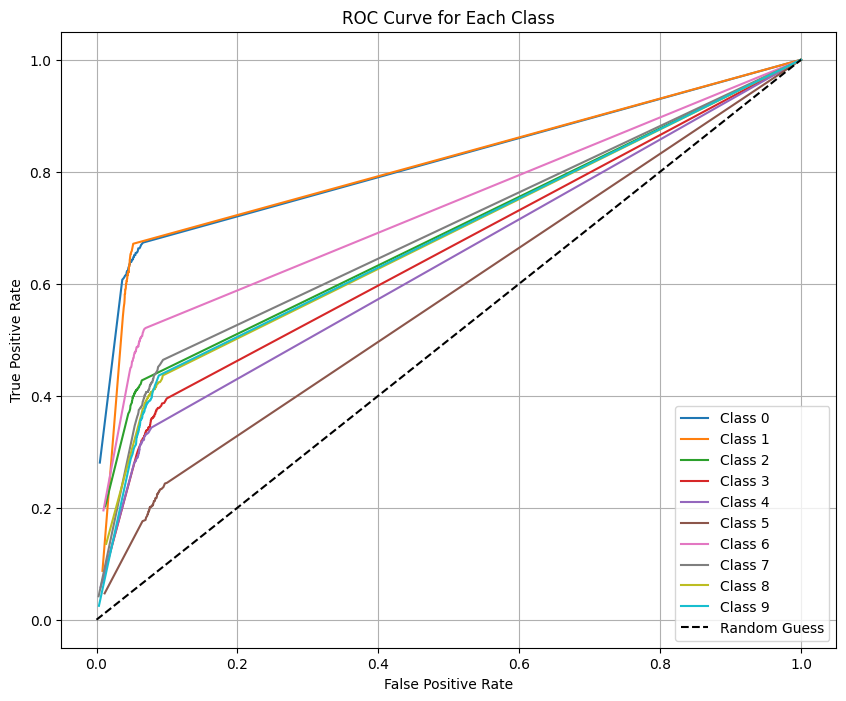

In [55]:
roc_data = compute_roc(one_hot(y_test, num_classes=10), y_pred_proba)

plt.figure(figsize=(10, 8))

for class_idx, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Class {class_idx}")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.grid()
plt.show()

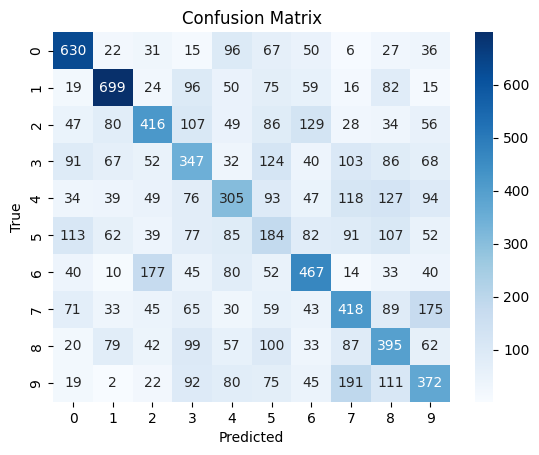

In [56]:
# === Confusion Matrix ===
cm = compute_confusion_matrix(y_test, y_pred_test, num_classes=10)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [57]:
print("=== Classification Report === Print TP, FP, FN, TN, precision, recall, f1 for each class and overall accuracy")
metrics = compute_metrics(cm)
for i in range(10):
    print(f"Class {i}:")
    print(f"TP: {metrics[i]['TP']}, FP: {metrics[i]['FP']}, FN: {metrics[i]['FN']}, TN: {metrics[i]['TN']}")
    print(f"Precision: {metrics[i]['Precision']:.4f}")
    print(f"Recall: {metrics[i]['Recall']:.4f}")
    print(f"F1 Score: {metrics[i]['F1 Score']:.4f}")
print(f"Overall Accuracy: {metrics['Accuracy']:.4f}")

=== Classification Report === Print TP, FP, FN, TN, precision, recall, f1 for each class and overall accuracy
Class 0:
TP: 630, FP: 454, FN: 350, TN: 8566
Precision: 0.5812
Recall: 0.6429
F1 Score: 0.6105
Class 1:
TP: 699, FP: 394, FN: 436, TN: 8471
Precision: 0.6395
Recall: 0.6159
F1 Score: 0.6275
Class 2:
TP: 416, FP: 481, FN: 616, TN: 8487
Precision: 0.4638
Recall: 0.4031
F1 Score: 0.4313
Class 3:
TP: 347, FP: 672, FN: 663, TN: 8318
Precision: 0.3405
Recall: 0.3436
F1 Score: 0.3420
Class 4:
TP: 305, FP: 559, FN: 677, TN: 8459
Precision: 0.3530
Recall: 0.3106
F1 Score: 0.3304
Class 5:
TP: 184, FP: 731, FN: 708, TN: 8377
Precision: 0.2011
Recall: 0.2063
F1 Score: 0.2037
Class 6:
TP: 467, FP: 528, FN: 491, TN: 8514
Precision: 0.4693
Recall: 0.4875
F1 Score: 0.4782
Class 7:
TP: 418, FP: 654, FN: 610, TN: 8318
Precision: 0.3899
Recall: 0.4066
F1 Score: 0.3981
Class 8:
TP: 395, FP: 696, FN: 579, TN: 8330
Precision: 0.3621
Recall: 0.4055
F1 Score: 0.3826
Class 9:
TP: 372, FP: 598, FN: 637,

100%|██████████| 60/60 [00:35<00:00,  1.68it/s, epoch=59, loss=5.9917] 


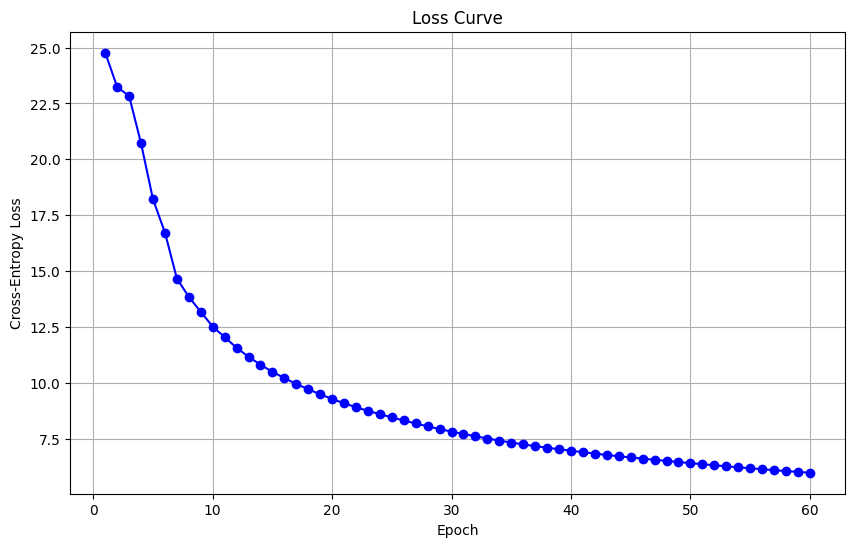

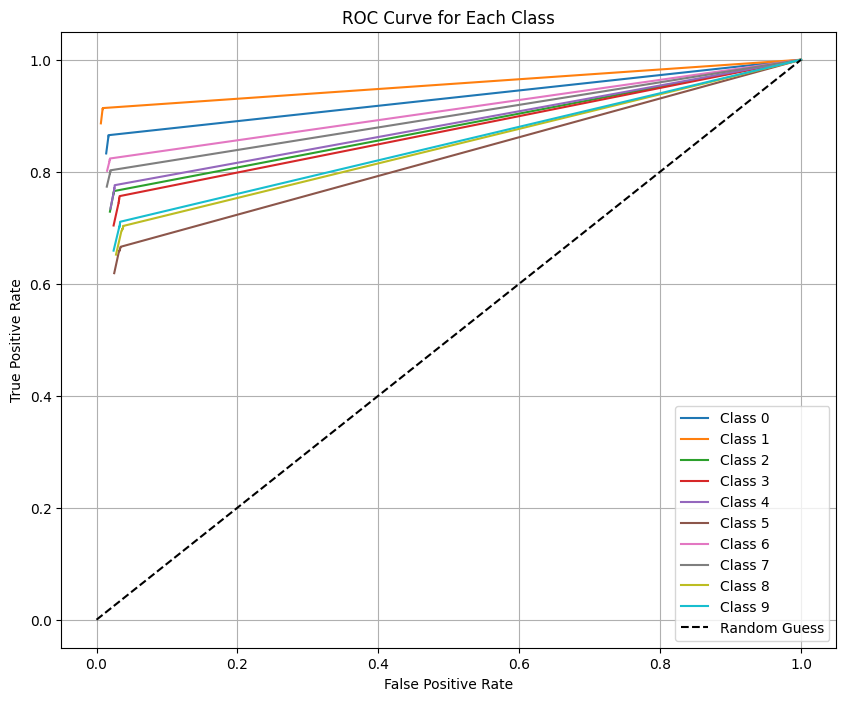

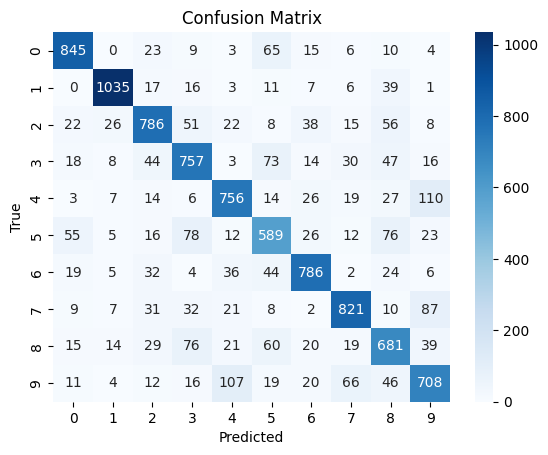

=== Classification Report === Print TP, FP, FN, TN, precision, recall, f1 for each class and overall accuracy
Class 0:
TP: 845, FP: 152, FN: 135, TN: 8868
Precision: 0.8475
Recall: 0.8622
F1 Score: 0.8548
Class 1:
TP: 1035, FP: 76, FN: 100, TN: 8789
Precision: 0.9316
Recall: 0.9119
F1 Score: 0.9216
Class 2:
TP: 786, FP: 218, FN: 246, TN: 8750
Precision: 0.7829
Recall: 0.7616
F1 Score: 0.7721
Class 3:
TP: 757, FP: 288, FN: 253, TN: 8702
Precision: 0.7244
Recall: 0.7495
F1 Score: 0.7367
Class 4:
TP: 756, FP: 228, FN: 226, TN: 8790
Precision: 0.7683
Recall: 0.7699
F1 Score: 0.7691
Class 5:
TP: 589, FP: 302, FN: 303, TN: 8806
Precision: 0.6611
Recall: 0.6603
F1 Score: 0.6607
Class 6:
TP: 786, FP: 168, FN: 172, TN: 8874
Precision: 0.8239
Recall: 0.8205
F1 Score: 0.8222
Class 7:
TP: 821, FP: 175, FN: 207, TN: 8797
Precision: 0.8243
Recall: 0.7986
F1 Score: 0.8113
Class 8:
TP: 681, FP: 335, FN: 293, TN: 8691
Precision: 0.6703
Recall: 0.6992
F1 Score: 0.6844
Class 9:
TP: 708, FP: 294, FN: 301,

In [59]:

best_weights, losses = train(X_train,
                             y_train,
                             input_size=784,
                             hidden1=256,
                             hidden2=128,
                             output_size=10,
                             epochs=60,
                             learning_rate=0.01,
                             seed=42)
plot_loss(losses)
y_pred_proba = predict_proba(X_test, best_weights)
y_pred_test = predict(X_test, best_weights)

# === ROC Curve ===
roc_data = compute_roc(one_hot(y_test, num_classes=10), y_pred_proba)
plt.figure(figsize=(10, 8))

for class_idx, (fpr, tpr) in enumerate(roc_data):
    plt.plot(fpr, tpr, label=f"Class {class_idx}")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.grid()
plt.show()

# === Confusion Matrix ===
cm = compute_confusion_matrix(y_test, y_pred_test, num_classes=10)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# === Classification Report === 
print("=== Classification Report === Print TP, FP, FN, TN, precision, recall, f1 for each class and overall accuracy")
metrics = compute_metrics(cm)
for i in range(10):
    print(f"Class {i}:")
    print(f"TP: {metrics[i]['TP']}, FP: {metrics[i]['FP']}, FN: {metrics[i]['FN']}, TN: {metrics[i]['TN']}")
    print(f"Precision: {metrics[i]['Precision']:.4f}")
    print(f"Recall: {metrics[i]['Recall']:.4f}")
    print(f"F1 Score: {metrics[i]['F1 Score']:.4f}")
print(f"Overall Accuracy: {metrics['Accuracy']:.4f}")